In [72]:
from models import CovidArimaModel
from dataproviders import CovidDataProvider
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats.mstats import winsorize
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta


In [73]:
dataprovider = CovidDataProvider()

In [74]:
arima_model = CovidArimaModel(dataprovider)

In [75]:
df = arima_model.get_covid_time_series()

<AxesSubplot: xlabel='Date_of_publication'>

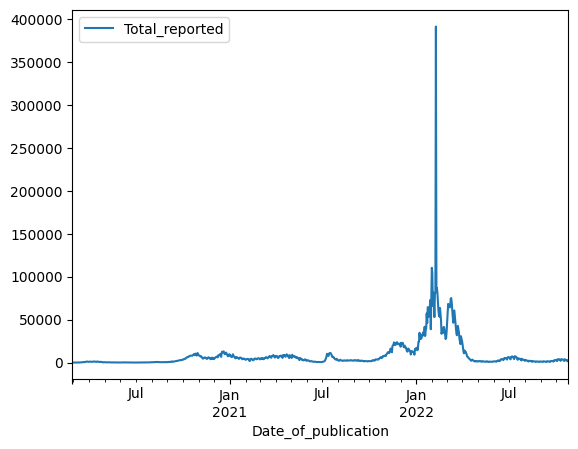

In [76]:
df.plot.line(y="Total_reported")

<AxesSubplot: >

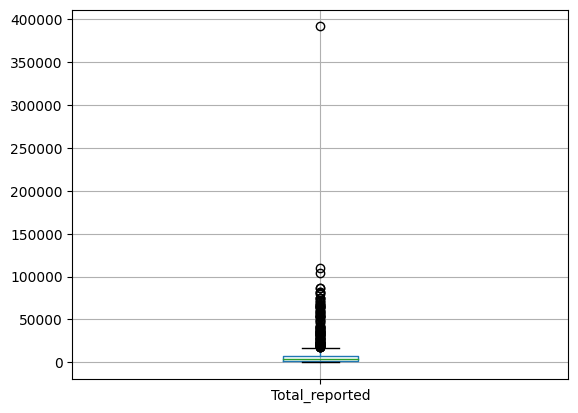

In [77]:
df.boxplot(['Total_reported'])

We can clearly see that there are a lot of outliers that may affect our prediction, we get rid of them by trimming all values that are in the 90% quartile

In [78]:
def winsorize_series(series: pd.Series, upper_bound: float) -> pd.Series:
    quantile = series.quantile(upper_bound)
    print(quantile)
    series[series > quantile] = quantile
    return series

In [79]:
df.Total_reported = winsorize_series(df.Total_reported, 0.90)

21756.0


C:\Users\joachim.verschelde\AppData\Local\Temp\ipykernel_33168\425493814.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[series > quantile] = quantile


<AxesSubplot: xlabel='Date_of_publication'>

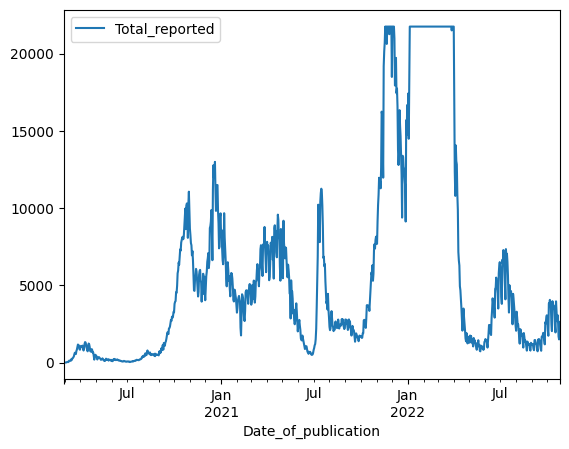

In [80]:
df.plot.line(y="Total_reported")

<AxesSubplot: >

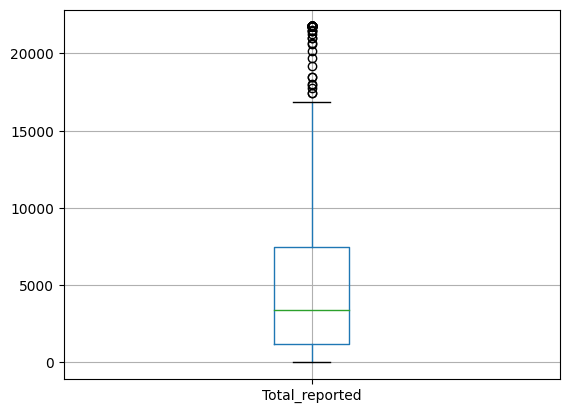

In [81]:
df.boxplot(['Total_reported'])

After taking care of the outliers, we see that our data is not stationary, so we take the 1st order difference

In [82]:
df['Total_reported_diff'] = df.Total_reported.diff(1)

<AxesSubplot: xlabel='Date_of_publication'>

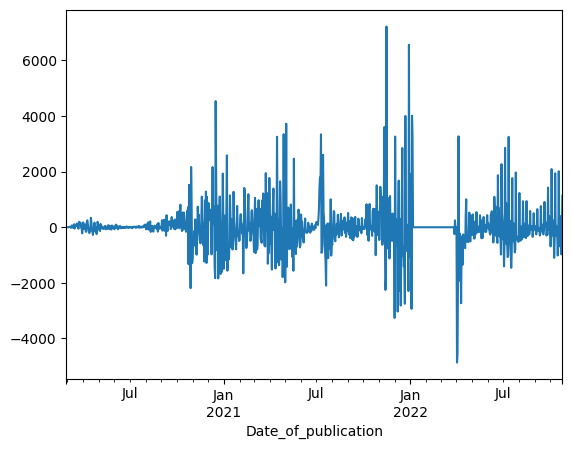

In [83]:
df.Total_reported_diff.plot()

c:\Users\joachim.verschelde\Desktop\Covid19Dashboard\cov-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


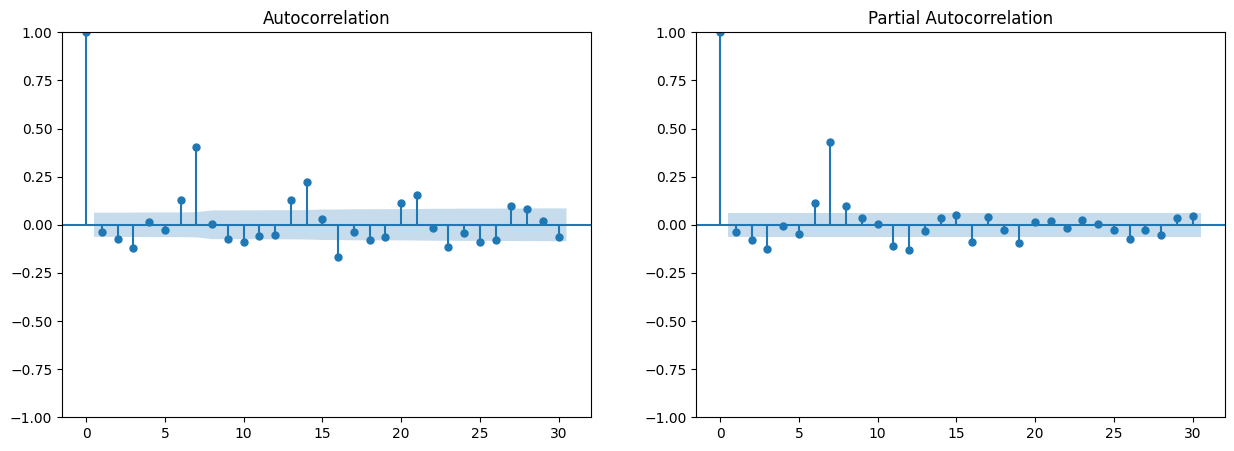

In [84]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
plot_acf(df.Total_reported_diff.dropna(), ax=ax1)
plot_pacf(df.Total_reported_diff.dropna(), ax=ax2)
plt.show()

After finetuning with different orders for the autoregressive and the moving average component, we came to the conclusion that AR4, MA4 with  1 level of differencing has the best results

In [85]:
arima_model = ARIMA(df.Total_reported, order=(4,1,4))

c:\Users\joachim.verschelde\Desktop\Covid19Dashboard\cov-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\joachim.verschelde\Desktop\Covid19Dashboard\cov-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\joachim.verschelde\Desktop\Covid19Dashboard\cov-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [86]:
model_fit = arima_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Total_reported   No. Observations:                  971
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -7851.334
Date:                Thu, 27 Oct 2022   AIC                          15720.668
Time:                        17:49:03   BIC                          15764.563
Sample:                    02-28-2020   HQIC                         15737.376
                         - 10-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2075      0.052     -3.968      0.000      -0.310      -0.105
ar.L2         -0.0144      0.036     -0.403      0.687      -0.085       0.056
ar.L3         -0.3265      0.035     -9.232      0.0

c:\Users\joachim.verschelde\Desktop\Covid19Dashboard\cov-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


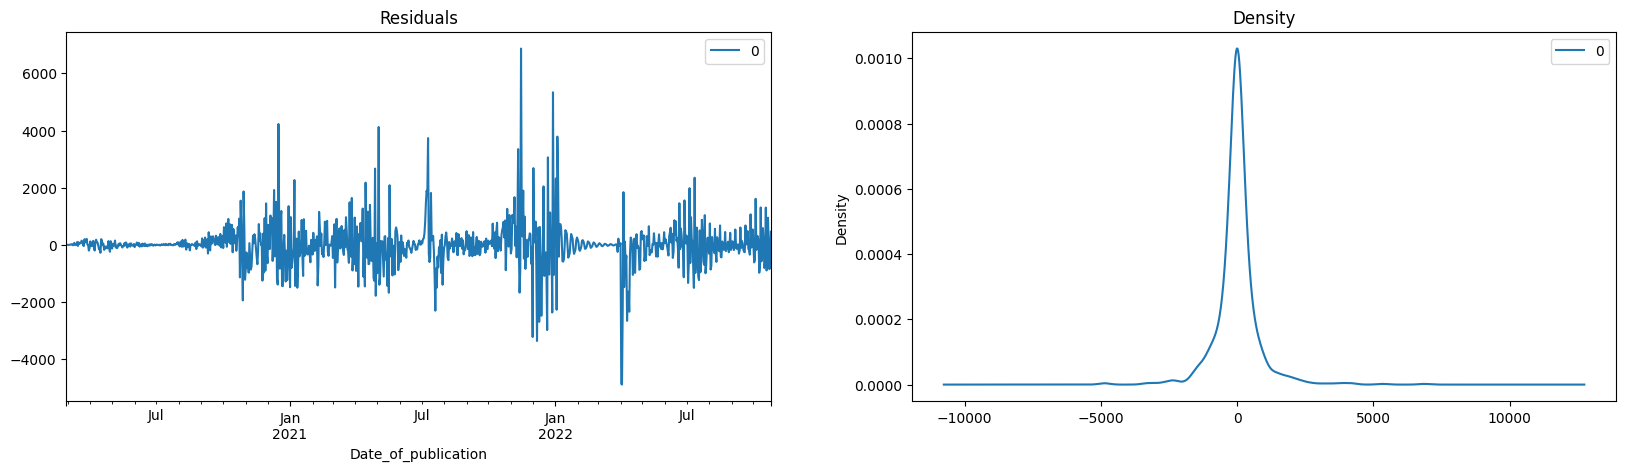

In [87]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [88]:
train = df.Total_reported[:-14]
test = df.Total_reported[-14:]
model = ARIMA(train, order=(4, 1, 4))  
fitted = model.fit()  

# Forecast
forecast = fitted.get_forecast(14)  # 95% conf
conf_interval = forecast.conf_int(alpha=0.05)
df['Prediction'] = forecast.predicted_mean
df = df.join(conf_interval)


c:\Users\joachim.verschelde\Desktop\Covid19Dashboard\cov-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\joachim.verschelde\Desktop\Covid19Dashboard\cov-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\joachim.verschelde\Desktop\Covid19Dashboard\cov-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\joachim.verschelde\Desktop\Covid19Dashboard\cov-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [89]:
conf_interval

,lower Total_reported,upper Total_reported
2022-10-12,2635.397593,5855.269337
2022-10-13,2009.945153,6389.400968
2022-10-14,912.324054,6091.871469
2022-10-15,287.950263,5907.417141
2022-10-16,-71.142619,6063.209277
2022-10-17,-57.209330,6634.855572
2022-10-18,247.244601,7572.010587
2022-10-19,114.349741,8139.431442
2022-10-20,-214.435639,8325.788223
2022-10-21,-848.716837,8115.026649


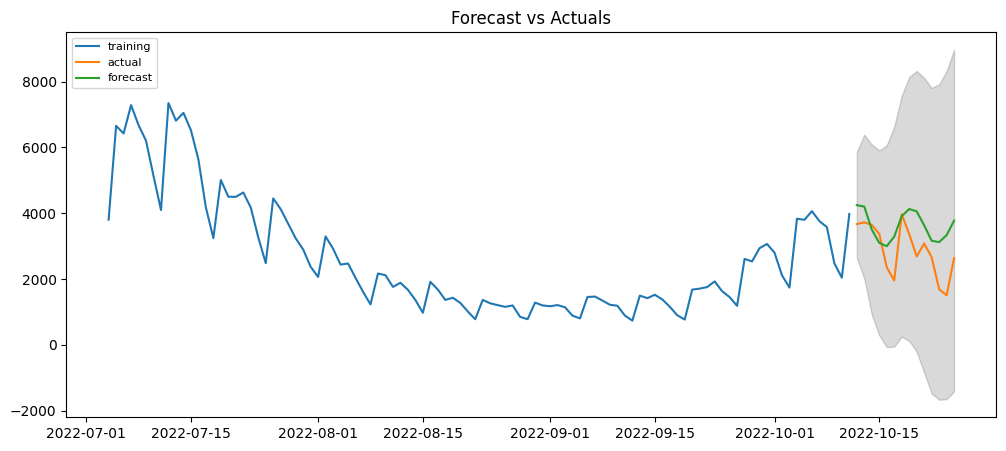

In [90]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-100:], label='training')
plt.plot(test, label='actual')
plt.plot(df.Prediction[-100:], label='forecast')
plt.fill_between(df['lower Total_reported'].index[-100:], df["lower Total_reported"][-100:], df['upper Total_reported'][-100:], 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()